In [ ]:
# ============================================================
# 0️⃣ Install Required Libraries
# ============================================================
!pip install pyspark
!pip install tensorflowonspark

In [ ]:
# ============================================================
# 1️⃣ Import Libraries
# ============================================================
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# PySpark
from pyspark.sql import SparkSession
from pyspark.ml.linalg import Vectors
from pyspark.ml.clustering import KMeans
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark import SparkContext

# TensorFlow
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.utils import to_categorical

# TensorFlowOnSpark
from tensorflowonspark import TFCluster

In [ ]:
# ============================================================
# 2️⃣ Initialize Spark
# ============================================================
spark = SparkSession.builder.appName("MNIST Big Data Assignment").getOrCreate()
sc = spark.sparkContext
print("Spark session ready!")

Spark session ready!


In [ ]:
# ============================================================
# 3️⃣ Load MNIST Dataset
# ============================================================
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
print(f"Original training set: {x_train.shape}, test set: {x_test.shape}")

Original training set: (60000, 28, 28), test set: (10000, 28, 28)


Displaying first 3 raw images:


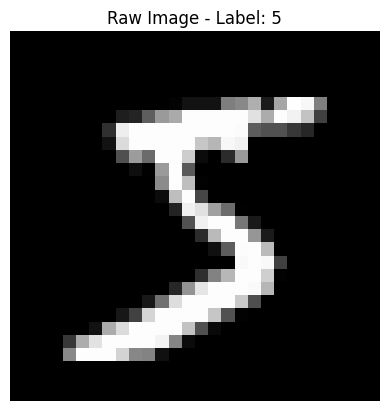

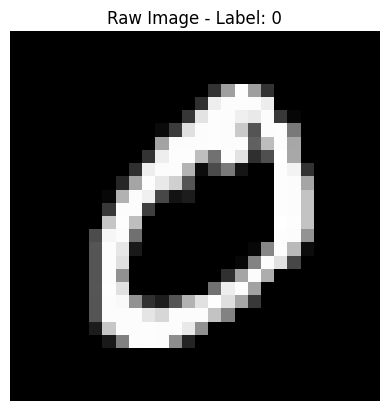

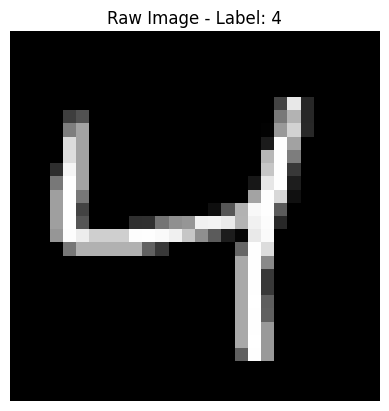

In [ ]:
# ============================================================
# 4️⃣ Display Raw Images
# ============================================================
print("Displaying first 3 raw images:")
for i in range(3):
    plt.imshow(x_train[i], cmap='gray')
    plt.title(f"Raw Image - Label: {y_train[i]}")
    plt.axis('off')
    plt.show()

In [ ]:
# ============================================================
# 5️⃣ Preprocessing for Spark MLlib (Subset for speed)
# ============================================================
n_train = 5000
n_test = 1000

x_train_small = x_train[:n_train]
y_train_small = y_train[:n_train]
x_test_small = x_test[:n_test]
y_test_small = y_test[:n_test]

# Normalize 0-1 and flatten
x_train_flat = (x_train_small / 255.0).reshape(n_train, -1)
x_test_flat = (x_test_small / 255.0).reshape(n_test, -1)

# Convert to Spark DataFrame via parallelize
train_rdd = sc.parallelize([(int(label), Vectors.dense(feat))
                            for label, feat in zip(y_train_small, x_train_flat)])
test_rdd = sc.parallelize([(int(label), Vectors.dense(feat))
                           for label, feat in zip(y_test_small, x_test_flat)])

train_df = train_rdd.toDF(["label", "features"])
test_df = test_rdd.toDF(["label", "features"])

print("First 5 rows of processed Spark DataFrame:")
train_df.show(5)

First 5 rows of processed Spark DataFrame:
+-----+--------------------+
|label|            features|
+-----+--------------------+
|    5|[0.0,0.0,0.0,0.0,...|
|    0|[0.0,0.0,0.0,0.0,...|
|    4|[0.0,0.0,0.0,0.0,...|
|    1|[0.0,0.0,0.0,0.0,...|
|    9|[0.0,0.0,0.0,0.0,...|
+-----+--------------------+
only showing top 5 rows



+-----+-------+
|label|cluster|
+-----+-------+
|    5|      0|
|    0|      9|
|    4|      2|
|    1|      6|
|    9|      5|
+-----+-------+
only showing top 5 rows

Displaying cluster centroids as images:


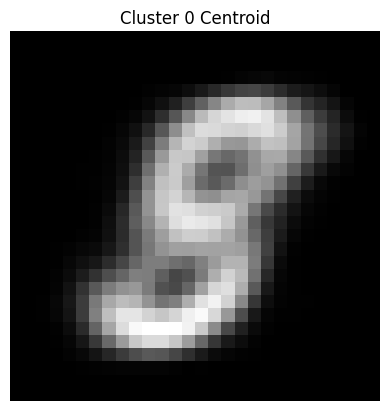

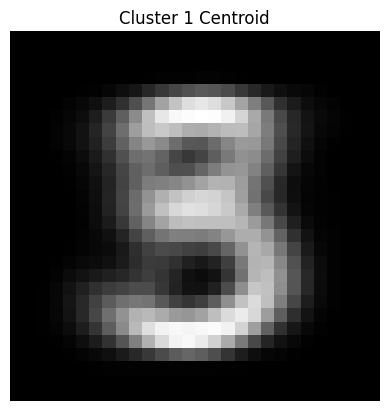

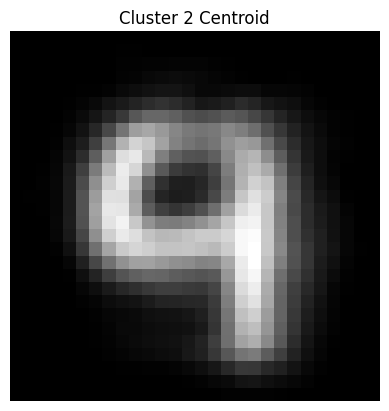

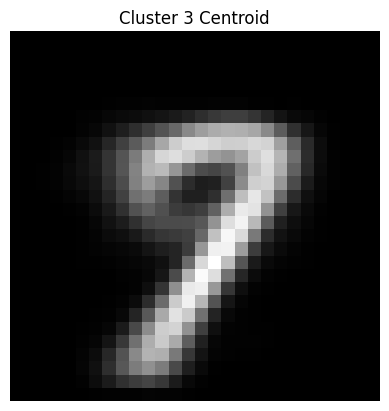

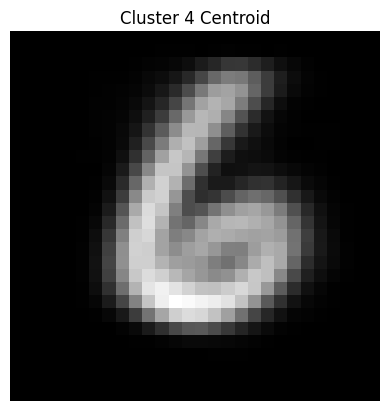

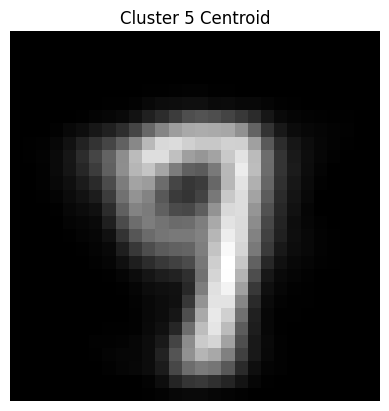

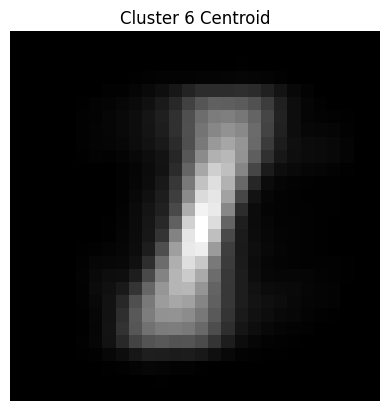

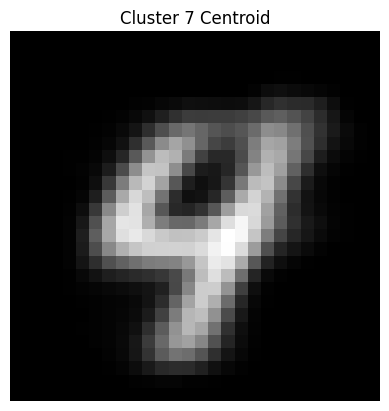

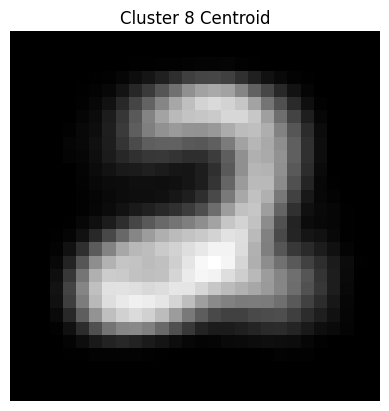

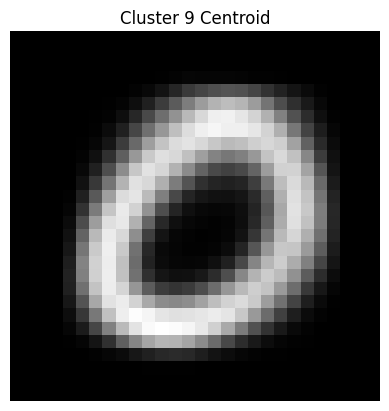

Cluster 0 mostly contains digit: 8
Cluster 1 mostly contains digit: 3
Cluster 2 mostly contains digit: 4
Cluster 3 mostly contains digit: 7
Cluster 4 mostly contains digit: 6
Cluster 5 mostly contains digit: 7
Cluster 6 mostly contains digit: 1
Cluster 7 mostly contains digit: 4
Cluster 8 mostly contains digit: 2
Cluster 9 mostly contains digit: 0


In [ ]:
# ============================================================
# 6️⃣ Unsupervised Learning: KMeans Clustering
# ============================================================
kmeans = KMeans(k=10, seed=42, featuresCol="features", predictionCol="cluster")
kmeans_model = kmeans.fit(train_df)

clustered_df = kmeans_model.transform(train_df)
clustered_df.select("label", "cluster").show(5)

print("Displaying cluster centroids as images:")
for i in range(10):
    centroid = kmeans_model.clusterCenters()[i].reshape(28,28)
    plt.imshow(centroid, cmap='gray')
    plt.title(f"Cluster {i} Centroid")
    plt.axis('off')
    plt.show()

# Map clusters to most common digit (using subset labels)
cluster_mapping = {}
for i in range(10):
    indices = np.where(np.array([row.cluster for row in clustered_df.collect()]) == i)[0]
    if len(indices) > 0:
        most_common = np.bincount(y_train_small[indices]).argmax()
        cluster_mapping[i] = most_common
        print(f"Cluster {i} mostly contains digit: {most_common}")

In [ ]:
# ============================================================
# 7️⃣ Supervised Learning: Logistic Regression
# ============================================================
lr = LogisticRegression(maxIter=50, featuresCol="features", labelCol="label")
lr_model = lr.fit(train_df)

predictions = lr_model.transform(test_df)
predictions.select("label", "prediction").show(5)

evaluator = MulticlassClassificationEvaluator(labelCol="label",
                                              predictionCol="prediction",
                                              metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print(f"Logistic Regression Accuracy (Spark MLlib): {accuracy*100:.2f}%")

+-----+----------+
|label|prediction|
+-----+----------+
|    7|       7.0|
|    2|       2.0|
|    1|       1.0|
|    0|       0.0|
|    4|       4.0|
+-----+----------+
only showing top 5 rows

Logistic Regression Accuracy (Spark MLlib): 85.90%


In [ ]:
# ============================================================
# 8️⃣ CNN with TensorFlowOnSpark (Optional)
# ============================================================
# Use same small subset for speed, reshape for CNN
x_train_cnn = x_train_small.reshape(-1, 28, 28, 1)
x_test_cnn = x_test_small.reshape(-1, 28, 28, 1)
y_train_cat = to_categorical(y_train_small, 10)
y_test_cat = to_categorical(y_test_small, 10)

cnn_model = Sequential([
    Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=(28,28,1)),
    MaxPooling2D(pool_size=(2,2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')
])

cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

print("Training CNN (simulated TensorFlowOnSpark)...")
cnn_model.fit(x_train_cnn, y_train_cat, validation_data=(x_test_cnn, y_test_cat),
              epochs=3, batch_size=128)

cnn_loss, cnn_acc = cnn_model.evaluate(x_test_cnn, y_test_cat)
print(f"CNN Accuracy (simulated TensorFlowOnSpark): {cnn_acc*100:.2f}%")

Training CNN (simulated TensorFlowOnSpark)...
Epoch 1/3


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 97ms/step - accuracy: 0.5077 - loss: 25.6531 - val_accuracy: 0.8350 - val_loss: 1.5787
Epoch 2/3
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - accuracy: 0.8984 - loss: 0.8206 - val_accuracy: 0.8810 - val_loss: 0.7258
Epoch 3/3
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 0.9348 - loss: 0.3374 - val_accuracy: 0.9020 - val_loss: 0.5362
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9192 - loss: 0.3766
CNN Accuracy (simulated TensorFlowOnSpark): 90.20%


MLlib Logistic Regression Predictions vs Actual:


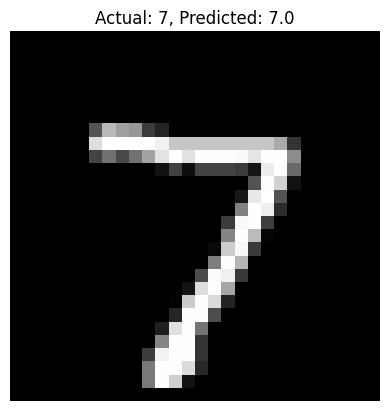

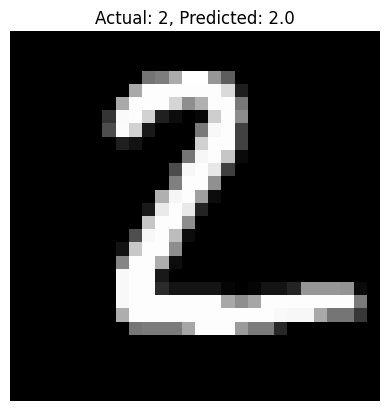

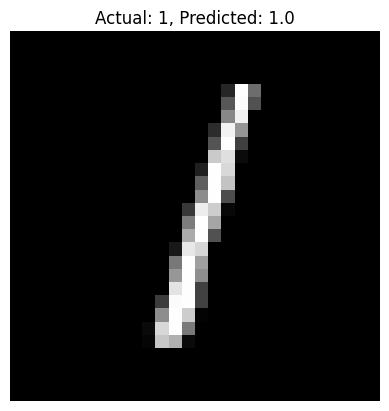

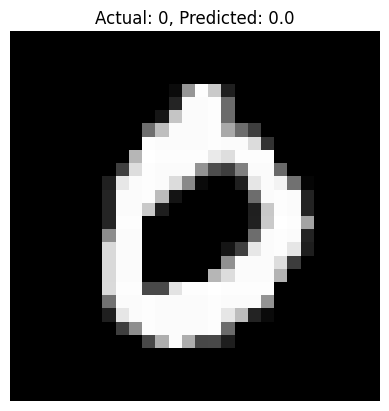

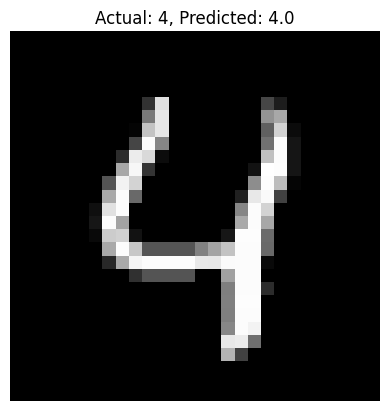

CNN Predictions vs Actual:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


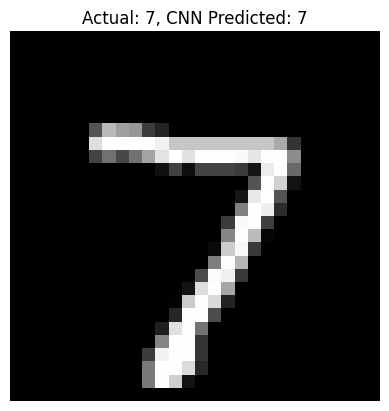

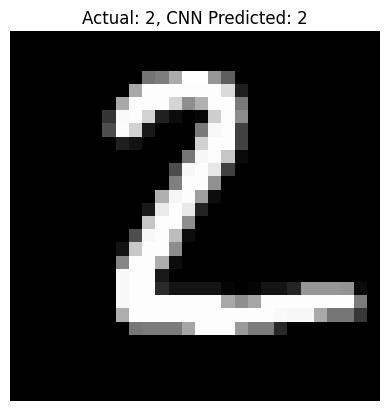

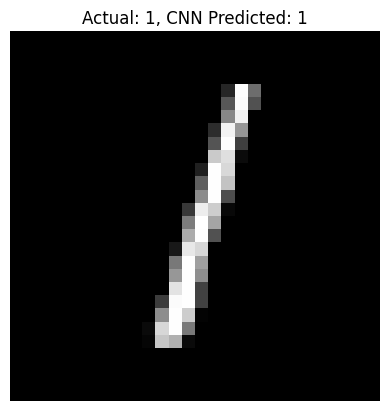

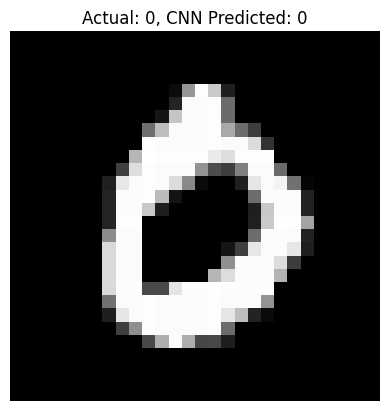

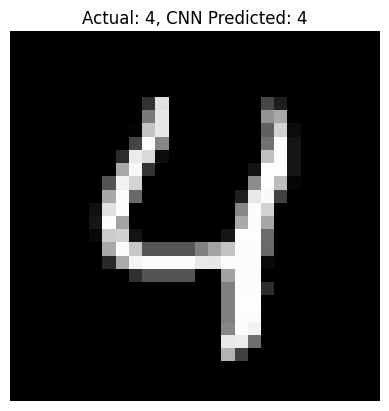

In [ ]:
# ============================================================
# 9️⃣ Show Sample Predictions
# ============================================================

# MLlib predictions
print("MLlib Logistic Regression Predictions vs Actual:")
preds = predictions.collect()
for i in range(5):
    plt.imshow(x_test_small[i], cmap='gray')
    plt.title(f"Actual: {y_test_small[i]}, Predicted: {preds[i].prediction}")
    plt.axis('off')
    plt.show()

# CNN predictions
print("CNN Predictions vs Actual:")
cnn_preds = np.argmax(cnn_model.predict(x_test_cnn[:5]), axis=1)
for i in range(5):
    plt.imshow(x_test_small[i], cmap='gray')
    plt.title(f"Actual: {y_test_small[i]}, CNN Predicted: {cnn_preds[i]}")
    plt.axis('off')
    plt.show()